<a href="https://colab.research.google.com/github/GerardoMunoz/road/blob/main/cars_cnn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
img_path='/content/images_road'

In [2]:
# prompt: Dounload and unzip url zip file

import requests
import zipfile
import io

url='https://github.com/GerardoMunoz/road/raw/refs/heads/main/dataset/cityscapes.zip'

try:
  response = requests.get(url, stream=True)
  response.raise_for_status()  # Raise an exception for bad status codes

  z = zipfile.ZipFile(io.BytesIO(response.content))
  z.extractall(img_path)
  print("Files extracted successfully.")

except requests.exceptions.RequestException as e:
  print(f"An error occurred during download: {e}")

except zipfile.BadZipFile:
  print(f"Invalid zip file.")

except Exception as e:
  print(f"An unexpected error occurred: {e}")


Files extracted successfully.


In [3]:
%cd '/content'
!pwd

/content
/content


In [4]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO/
!pip install -q -e .

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 22.5 MB/s eta 0:00:00


In [5]:
%cd '/content'
!mkdir weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth -P weights
!pwd

/content
/content


In [6]:
!pip install supervision

* Entorno de ejecución -> Reiniciar sesión
* Entorno de ejecución -> Ejecutar celda y las de abajo

In [57]:
from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model("/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
     "weights/groundingdino_swint_ogc.pth")

final text_encoder_type: bert-base-uncased


In [58]:
text='car'#'pedestrian, veicle'
BOX_THRESHOLD = 0.26
TEXT_TRHESHOLD = 0.30


In [ ]:
# import os
# import supervision as sv
# #img_path="/content/val2017/000000032901.jpg"
# text="road"#"T-Shirt Shirt Sweater Hoodie Jacket"
# BOX_THRESHOLD = 0.26
# TEXT_TRHESHOLD = 0.30
# image_source, image = load_image(img_path)
# boxes, logits,  phrases = predict(
#     model=model,
#     image=image,
#     caption=text,
#     box_threshold=BOX_THRESHOLD,
#     text_threshold=TEXT_TRHESHOLD,
#     device='cuda'
# )
# annotated_frame = annotate(
#     image_source=image_source,
#     boxes=boxes,
#     logits=logits,
#     phrases=phrases)

# sv.plot_image(annotated_frame,(16,16))

In [ ]:
# boxes, logits,  phrases

[center_x(cx), center_y(cy),  right_x(rx), top_x(tx)]

* left,right,center,top,buttom

* cx=(rx+lx)/2
* lx=-rx+2cx

* cy=(by+ty)/2
* by=2cy-ty

[lx, ty, rx, by]

In [74]:
code={}

def yolo_format(boxes, logits,  phrases, alpha=0.5):
    yolo=[]
    for box, logit,  phrase in zip(boxes, logits,  phrases):
        if logit>alpha:
            if phrase not in code:
                code[phrase]=len(code)+1
            #cx,cy,rx,ty=box
            #lx=-rx+2*cx
            #by=2*cy-ty
            #print('box,cx,cy,rx,ty,lx,by',box,lx,by,logit)
            #yolo.append([code[phrase],lx,ty,rx-lx,by-ty])
            yolo.append([code[phrase],*box])
    print(yolo)
    return yolo


# boxes_list =yolo_format(boxes, logits,  phrases)
# boxes_list

In [75]:
# file_path = "label"+img_name[:-4]+".txt"

# # Write the list of tensors to a file
# with open(file_path, "w") as file:
#     for item in boxes_list:
#         # Extract the first element (integer) and the tensors
#         class_id = item[0]
#         tensor_values = [t.item() for t in item[1:]]  # Convert tensors to floats
#         # Combine the integer and tensor values into one line
#         file.write(f"{class_id} " + " ".join(map(lambda x:f"{x:.4f}", tensor_values)) + "\n")

# print(f"File saved at {file_path}")

In [78]:
def save_labels(img_path,label_path,show=False):
    #file_path = "label"+img_name[:-4]+".txt"

    image_source, image = load_image(img_path)
    boxes, logits,  phrases = predict(
        model=model,
        image=image,
        caption=text,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_TRHESHOLD,
        #device='cuda'
    )

    if show:
        annotated_frame = annotate(
            image_source=image_source,
            boxes=boxes,
            logits=logits,
            phrases=phrases)

        sv.plot_image(annotated_frame,(16,16))

    boxes_list =yolo_format(boxes, logits,  phrases)

    # Write the list of tensors to a file
    with open(label_path, "w") as file:
        for item in boxes_list:
            # Extract the first element (integer) and the tensors
            class_id = item[0]
            tensor_values = [t.item() for t in item[1:]]  # Convert tensors to floats
            # Combine the integer and tensor values into one line
            file.write(f"{class_id} " + " ".join(map(lambda x:f"{x:.4f}", tensor_values)) + "\n")
    print('.',end="")
    #print(f"File saved at {file_path}")


/content/images_road/10.jpg /content/yolo_labels_car/10.txt


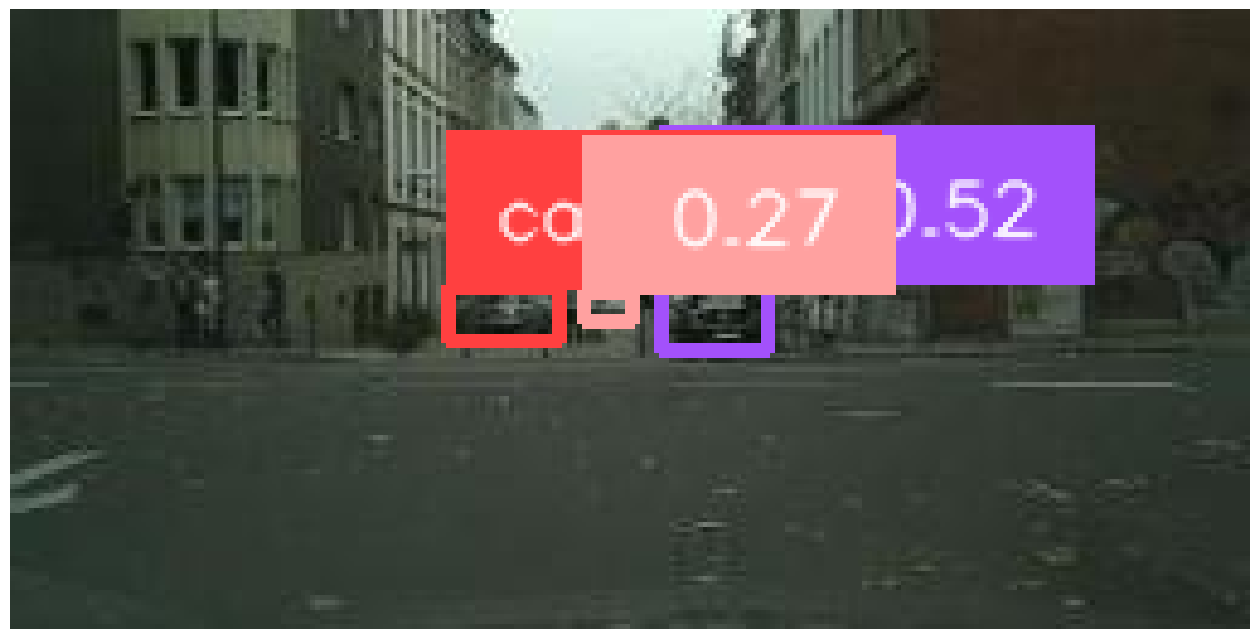

[[1, tensor(0.5672), tensor(0.4990), tensor(0.0871), tensor(0.1089)], [1, tensor(0.3987), tensor(0.4905), tensor(0.0870), tensor(0.0816)]]
.

In [79]:
in_path='/content/images_road/'
out_path='/content/yolo_labels_car/'
img_name='10'
img_path=in_path+img_name+'.jpg'
lbl_path=out_path+img_name+'.txt'
print(img_path,lbl_path)


save_labels(img_path,lbl_path,show=True)

In [ ]:
# prompt: salve_labels for all files in in_path

import os

def salve_labels_for_all_files(in_path, out_path):
    for filename in os.listdir(in_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust extensions as needed
            img_name = filename[:-4] # remove extension
            img_path = os.path.join(in_path, filename)
            lbl_path = os.path.join(out_path, img_name + '.txt')
            print(img_path, lbl_path)
            save_labels(img_path, lbl_path)

# Example usage
# in_path = '/content/images_road/'
# out_path = '/content/yolo_labels_2/'

# Create the output directory if it doesn't exist
os.makedirs(out_path, exist_ok=True)

salve_labels_for_all_files(in_path, out_path)

/content/images_road/1926.jpg /content/yolo_labels_car/1926.txt
[[1, tensor(0.6039), tensor(0.4832), tensor(0.2637), tensor(0.2180)], [1, tensor(0.4597), tensor(0.4559), tensor(0.2005), tensor(0.1959)], [1, tensor(0.8414), tensor(0.4515), tensor(0.1767), tensor(0.1959)]]
./content/images_road/2157.jpg /content/yolo_labels_car/2157.txt
[[1, tensor(0.9084), tensor(0.5719), tensor(0.1820), tensor(0.6374)]]
./content/images_road/1329.jpg /content/yolo_labels_car/1329.txt
[[1, tensor(0.1280), tensor(0.4953), tensor(0.2554), tensor(0.6319)]]
./content/images_road/246.jpg /content/yolo_labels_car/246.txt
[[1, tensor(0.4096), tensor(0.4388), tensor(0.0866), tensor(0.1235)], [1, tensor(0.5725), tensor(0.4888), tensor(0.1737), tensor(0.2952)]]
./content/images_road/2347.jpg /content/yolo_labels_car/2347.txt
[[1, tensor(0.1988), tensor(0.4918), tensor(0.0942), tensor(0.1477)], [1, tensor(0.5978), tensor(0.4399), tensor(0.0763), tensor(0.1193)]]
./content/images_road/465.jpg /content/yolo_labels_c

In [23]:
# prompt: zip all files of out_path

import os
import zipfile

def zip_files(directory_path, zip_filename):
  """Zips all files in the specified directory."""
  try:
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
      for root, _, files in os.walk(directory_path):
        for file in files:
          file_path = os.path.join(root, file)
          zipf.write(file_path, arcname=os.path.relpath(file_path, directory_path))
    print(f"Successfully zipped files to {zip_filename}")
  except Exception as e:
    print(f"An error occurred while zipping files: {e}")

# Example usage:
out_path = '/content/yolo_labels_2'
zip_filename = '/content/yolo_labels__2.zip' # Specify the desired zip file name
zip_files(out_path, zip_filename)

Successfully zipped files to /content/yolo_labels_2.zip


Train

In [49]:
images_path='/content/images_road'
labels_path='/content/yolo_labels_car'


In [50]:
import os
import cv2
import numpy as np
import tensorflow as tf

# Define the path to the image and label files
images_path = '/content/images_road'
#labels_path = '/content/converted_labels'  # Assuming labels were already converted

class ObjectDetectionGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, label_dir, batch_size=32, image_size=(224, 224)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        bboxes = []

        for file in batch_files:
            print(file, end=" ")
            # Load image
            image_path = os.path.join(self.image_dir, file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, self.image_size)
            image = image / 255.0  # Normalize to [0, 1]

            # Load corresponding label
            label_path = os.path.join(self.label_dir, file.replace('.jpg', '.txt'))
            with open(label_path, 'r') as f:
                lines = f.readlines()

            boxes = []
            for line in lines:
                if line.count(',') == 0:
                    parts = line.split()
                else:
                    parts = line.split(',')
                _, xmin, ymin, xmax, ymax, _ = parts
                xmin = float(xmin)
                ymin = float(ymin)
                xmax = float(xmax)
                ymax = float(ymax)
                boxes.append([xmin, ymin, xmax, ymax])
            # if boxes==[]:
            #     continue

            # Pad boxes if necessary
            boxes = np.array(boxes)
            if len(boxes) == 0:
                boxes = np.zeros((1, 4))  # No boxes in the image
            if len(boxes) < 2:
                boxes = np.pad(boxes, ((0, 1), (0, 0)))  # Ensure 2 boxes are available

            # Append image and bounding boxes
            images.append(image)
            bboxes.append(boxes)

        return np.array(images), np.array(bboxes)

    def on_epoch_end(self):
        # Shuffle the images and labels after each epoch (optional)
        self.indexes = np.arange(len(self.image_files))
        np.random.shuffle(self.indexes)

# Instantiate the generator
train_generator = ObjectDetectionGenerator(image_dir=images_path, label_dir=labels_path, batch_size=32)


In [51]:
# Load pre-trained MobileNet model (without the top classification layer)
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False)

# Add custom head for object detection (bounding box regression)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(4, activation='sigmoid')(x)  # 4 values: [xmin, ymin, xmax, ymax]
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model using the generator
model.fit(train_generator, epochs=10)


1926.jpg 

ValueError: not enough values to unpack (expected 6, got 5)

In [36]:
train_generator

In [33]:
import tensorflow as tf
import os

def load_image(image_path, image_size=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def load_labels(label_path):
    # Read the labels in YOLO format (or any other format you have)
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        parts = line.split()
        x_center, y_center, width, height = map(float, parts[1:5])
        xmin = x_center - width / 2
        ymin = y_center - height / 2
        xmax = x_center + width / 2
        ymax = y_center + height / 2
        boxes.append([xmin, ymin, xmax, ymax])
    return tf.convert_to_tensor(boxes, dtype=tf.float32)

# Loading the entire dataset into memory
def load_data(image_dir, label_dir, image_size=(256, 128)):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
    label_paths = [os.path.join(label_dir, f.replace('.jpg', '.txt')) for f in os.listdir(image_dir) if f.endswith('.jpg')]

    images = []
    labels = []

    for image_path, label_path in zip(image_paths, label_paths):
        images.append(load_image(image_path, image_size))
        labels.append(load_labels(label_path))

    # Convert lists to tensors
    images_tensor = tf.stack(images)
    labels_tensor = tf.stack(labels)

    return images_tensor, labels_tensor


In [34]:
load_data(images_path, labels_path, image_size=(224, 224))

ValueError: could not convert string to float: '381,'

In [31]:
# prompt: Create a function that create the tensor with the images /content/images_road of a specific batch

import supervision as sv
import os
import torch

def create_tensor_from_images(image_dir, batch_size=32):
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"No images found in {image_dir}")
        return None

    # Placeholder for image tensors
    image_tensors = []

    for image_file in image_files:
      image_path = os.path.join(image_dir, image_file)

      try:
          image_source, image = load_image(image_path)
          # Convert the image to a tensor (assuming you want to use PyTorch)
          image_tensor = torch.tensor(image).permute(2, 0, 1).float()  # Adjust as needed for your model's input format
          image_tensors.append(image_tensor)
      except Exception as e:
        print(f"Error loading image {image_file}: {e}")
        continue

    # Batching
    batched_tensors = []
    for i in range(0, len(image_tensors), batch_size):
        batch = image_tensors[i:i + batch_size]
        batched_tensors.append(torch.stack(batch))

    return batched_tensors

In [32]:
# prompt: test create_tensor_from_images

import os
import torch
from groundingdino.util.inference import load_image

def create_tensor_from_images(image_dir, batch_size=32):
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"No images found in {image_dir}")
        return None

    # Placeholder for image tensors
    image_tensors = []

    for image_file in image_files:
      image_path = os.path.join(image_dir, image_file)

      try:
          image_source, image = load_image(image_path)
          # Convert the image to a tensor (assuming you want to use PyTorch)
          image_tensor = torch.tensor(image).permute(2, 0, 1).float()  # Adjust as needed for your model's input format
          image_tensors.append(image_tensor)
      except Exception as e:
        print(f"Error loading image {image_file}: {e}")
        continue

    # Batching
    batched_tensors = []
    for i in range(0, len(image_tensors), batch_size):
        batch = image_tensors[i:i + batch_size]
        batched_tensors.append(torch.stack(batch))

    return batched_tensors

In [30]:
import tensorflow as tf
import os
import cv2
import numpy as np

# Paths
images_path = '/content/images_road'
labels_path = '/content/converted_labels'  # Converted labels in [xmin, ymin, xmax, ymax]

# Helper function to load and preprocess the image
def load_image(image_path, image_size=(224, 224)):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image to tensor (assuming .jpg format)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to the desired shape
    image = tf.image.resize(image, image_size)
    # Normalize the image to the range [0, 1]
    image = image / 255.0
    return image

# Helper function to load and process the bounding boxes
def load_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Extract bounding boxes from the YOLO format
    boxes = []
    for line in lines:
        parts = line.split()
        _, x_center, y_center, width, height, _ = parts
        xmin = float(x_center) - float(width) / 2
        ymin = float(y_center) - float(height) / 2
        xmax = float(x_center) + float(width) / 2
        ymax = float(y_center) + float(height) / 2
        boxes.append([xmin, ymin, xmax, ymax])

    # Return the bounding boxes as a tensor
    return tf.convert_to_tensor(boxes, dtype=tf.float32)

# Function to process images and labels into a dataset
def load_data(image_dir, label_dir, image_size=(224, 224)):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
    label_paths = [os.path.join(label_dir, f.replace('.jpg', '.txt')) for f in os.listdir(image_dir) if f.endswith('.jpg')]

    # Ensure both image and label paths match
    assert len(image_paths) == len(label_paths), "Mismatch between images and labels"

    # Create a TensorFlow dataset from image paths and label paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    # Map the load and preprocess functions to the dataset
    def process_data(image_path, label_path):
        image = load_image(image_path, image_size)
        labels = load_labels(label_path)
        return image, labels

    dataset = dataset.map(process_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Optionally shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

# Load the dataset
train_dataset = load_data(images_path, labels_path, image_size=(224, 224))

# Example: Iterate through the dataset (to visualize or check the output)
for images, labels in train_dataset.take(1):
    print(images.shape)  # Shape of the images tensor
    print(labels.shape)  # Shape of the labels tensor


TypeError: in user code:

    File "<ipython-input-30-3343562cb9e0>", line 55, in process_data  *
        labels = load_labels(label_path)
    File "<ipython-input-30-3343562cb9e0>", line 24, in load_labels  *
        with open(label_path, 'r') as f:

    TypeError: expected str, bytes or os.PathLike object, not SymbolicTensor


In [29]:
# Load pre-trained MobileNet model (without the top classification layer)
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False)

# Add custom head for object detection (bounding box regression)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(4, activation='sigmoid')(x)  # 4 values: [xmin, ymin, xmax, ymax]
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model using the generated tensor dataset
model.fit(train_dataset, epochs=10)


NameError: name 'train_dataset' is not defined

In [26]:
import tensorflow as tf

# Example: Train a simple MobileNet-based model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base layers

# Add custom classification head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(5)(x)  # Example with 5 output classes
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Assuming you have `train_dataset` and `val_dataset` ready
# model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Save the model in the TensorFlow SavedModel format
model.save("saved_model/my_model")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_model/my_model.

In [27]:
import os
import cv2

# Paths
images_path = '/content/images_road'
labels_path = '/content/yolo_labels_car'
output_path = '/content/converted_labels'

# Create output folder
os.makedirs(output_path, exist_ok=True)

# Function to convert YOLO to absolute coordinates
def convert_yolo_to_bbox(yolo_line, img_width, img_height):
    _, x_center, y_center, width, height = map(float, yolo_line.split())
    xmin = int((x_center - width / 2) * img_width)
    ymin = int((y_center - height / 2) * img_height)
    xmax = int((x_center + width / 2) * img_width)
    ymax = int((y_center + height / 2) * img_height)
    return xmin, ymin, xmax, ymax

# Process each image and label
for label_file in os.listdir(labels_path):
    if not label_file.endswith('.txt'):
        continue

    # Get corresponding image
    image_file = os.path.splitext(label_file)[0] + '.jpg'
    image_path = os.path.join(images_path, image_file)
    label_path = os.path.join(labels_path, label_file)

    if not os.path.exists(image_path):
        print(f"Image not found for {label_file}, skipping...")
        continue

    # Load image to get dimensions
    img = cv2.imread(image_path)
    img_height, img_width, _ = img.shape

    # Read and convert label
    with open(label_path, 'r') as f:
        lines = f.readlines()

    converted_lines = []
    for line in lines:
        xmin, ymin, xmax, ymax = convert_yolo_to_bbox(line, img_width, img_height)
        converted_lines.append(f"{image_file}, {xmin}, {ymin}, {xmax}, {ymax}, car\n")

    # Save converted labels
    output_label_file = os.path.join(output_path, label_file)
    with open(output_label_file, 'w') as f:
        f.writelines(converted_lines)


In [28]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Add custom head for object detection
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(4, activation='sigmoid')(x)  # Bounding box regression
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train on your data
# Ensure `train_generator` yields (image, bbox) pairs
model.fit(train_generator, epochs=10, validation_data=val_generator)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


NameError: name 'train_generator' is not defined